In [2]:
from jax import random as  jr
from jax import numpy as jnp
from jax import jit
from itertools import count

from dynamax.linear_gaussian_ssm.inference import lgssm_smoother
from dynamax.linear_gaussian_ssm.models.linear_gaussian_ssm import LinearGaussianSSM

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16, 9]

### Generate synthetic data and run HMC with all but covariance matrices frozen

  0%|          | 0/500 [00:00<?, ?it/s]

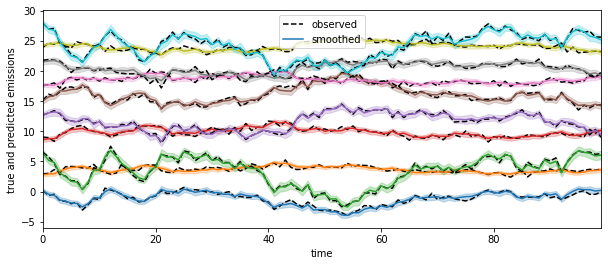

In [3]:
# Simulate synthetic data from true model
state_dim = 2
emission_dim = 10
num_timesteps = 100
keys = map(jr.PRNGKey, count())

true_model = LinearGaussianSSM.random_initialization(next(keys), state_dim, emission_dim)
true_states, emissions = true_model.sample(next(keys), num_timesteps)

# Initilize parameters by fitting EM algorithm
num_iters = 2000
test_model = LinearGaussianSSM(
    dynamics_matrix=true_model.dynamics_matrix.value,
    emission_matrix=true_model.emission_matrix.value,
    initial_mean=true_model.initial_mean.value,
    initial_covariance=true_model.initial_covariance.value,
    dynamics_input_weights=true_model.dynamics_input_weights.value,
    emission_input_weights=true_model.emission_input_weights.value,
    dynamics_covariance=jnp.eye(state_dim),
    emission_covariance=jnp.eye(emission_dim)
)

# Freeze transition parameters and inital parameters, so that only covariance matrices are learned
test_model.dynamics_matrix.freeze()
test_model.emission_matrix.freeze()
test_model.initial_mean.freeze()
test_model.initial_covariance.freeze()
test_model.dynamics_input_weights.freeze()
test_model.emission_input_weights.freeze()
test_model.dynamics_bias.freeze()
test_model.emission_bias.freeze()

sample_size = 500
param_samples = test_model.fit_hmc(
    next(keys), sample_size, jnp.array([emissions]), batch_inputs=None, num_integration_steps=30)

@jit
def smooth_emission(params):
    posterior = lgssm_smoother(params, emissions)
    return posterior.smoothed_means @ params.emission_matrix.T + params.emission_bias

smoothed_emissions = jnp.array([smooth_emission(params) for params in param_samples])
smoothed_emissions_means = smoothed_emissions.mean(axis=0)
smoothed_emissions_stds = jnp.std(smoothed_emissions, axis=0)

spc = 3
plt.figure(figsize=(10, 4))
for i in range(emission_dim):
    plt.plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
    ln = plt.plot(smoothed_emissions_means[:, i] + spc * i,
                  label="smoothed" if i == 0 else None)[0]
    plt.fill_between(
        jnp.arange(num_timesteps),
        spc * i + smoothed_emissions_means[:, i] - 2 * jnp.sqrt(smoothed_emissions_stds[:, i]),
        spc * i + smoothed_emissions_means[:, i] + 2 * jnp.sqrt(smoothed_emissions_stds[:, i]),
        color=ln.get_color(),
        alpha=0.25,
    )
plt.xlabel("time")
plt.xlim(0, num_timesteps - 1)
plt.ylabel("true and predicted emissions")
plt.legend()